In [1]:
# import tensorflow as tf
import numpy as np
import os
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import io
from PIL import Image, ImageDraw
from io import BytesIO
import cv2
import math
%matplotlib inline

In [2]:
limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]

In [3]:
def skeleton_image(joints_2d, img):
    img_copy = img.copy()
#     colors = [(0,0,255), (0,255,0), (255,0,0), (255,0,255), (0,255,255), (255,255,0), (127,127,0), (0,127,0), (100,0,100), 
#           (255,0,255), (0,255,0), (0,0,255), (255,255,0), (127,127,0), (100,0,100), (50, 255, 100), (50, 50, 0)]
    
    colors = [(0,0,255), (0,255,0), (255,0,0), (255,0,255), (0,255,255), (255,255,0), (127,127,0), (0,127,0), (100,0,100), 
          (255,0,255), (0,255,0), (0,0,255), (255,255,0), (127,127,0), (100,0,100), (175,100,195), (255,125,25)]
    joints_2d = joints_2d
    for i in range(joints_2d.shape[0]):
        #         ax.text(joints_2d[i, 0], -joints_2d[i, 1], str(i))
        x_pair = [joints_2d[i, 0], joints_2d[limb_parents[i], 0]]
        y_pair = [joints_2d[i, 1], joints_2d[limb_parents[i], 1]]
        img_copy = cv2.line(img_copy, (int(x_pair[0]),int(y_pair[0])), (int(x_pair[1]),int(y_pair[1])), colors[i],4)

    return img_copy[:,:,::-1]

In [4]:
def get_gaussian_maps(mu, shape_hw, inv_std1, inv_std2, angles, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    mu_y, mu_x = mu[:, 0:1], mu[:, 1:2]     # (17, 1)

#     y = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[0]))

#     x = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[1]))
    
    
    y = []
    x = []
    for i in range(shape_hw[0]):
        y.append(np.linspace(-1.0, 1.0, shape_hw[0]))
        x.append(np.linspace(-1.0, 1.0, shape_hw[1]))
    y = np.stack(y, 0)
    x = np.stack(x, 0).T
    y = np.expand_dims(y, 0)
    x = np.expand_dims(x, 0)
    for i in range(mu.shape[0]-1):
        y = np.concatenate([y, y[0:1]],0)
        x = np.concatenate([x, x[0:1]],0)

    print (x.shape)
    print (y.shape)
    if mode in ['rot', 'flat']:
                
        mu_y, mu_x = np.expand_dims(mu_y, -1), np.expand_dims(mu_x, -1)

        g_y = np.square(y - mu_y)   # (17, 14, 14)
        g_x = np.square(x - mu_x)   # (17, 14, 14)
        
        dist = (g_y * inv_std1**2 + g_x * inv_std2**2)

        if mode == 'rot':
            g_yx = np.exp(-dist)

        else:
            g_yx = np.exp(-np.pow(dist + 1e-5, 0.25))

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    print (g_yx.shape)
#     g_yx = np.transpose(g_yx, axes=[1, 2, 0])
    g_yx = np.transpose(g_yx, axes=[2, 1, 0])

    return g_yx#, g_yx1

In [5]:
def get_rot_gaussian_maps(mu_set, shape_hw, inv_std1, inv_std2, angles, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    im_len = len(mu_set)
    inv_std1 = np.expand_dims(np.expand_dims(inv_std1, 1), 1)
    inv_std2 = np.expand_dims(np.expand_dims(inv_std2, 1), 1)
    gaussians = []
    
    for i in range(im_len):
    
        mu_y, mu_x = mu_set[i][:, 0:1], mu_set[i][:, 1:2]     # (17, 1)

#     y = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[0]))

#     x = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[1]))

    
        y = []
        x = []
        for _ in range(shape_hw[0]):
            y.append(np.linspace(-1.0, 1.0, shape_hw[0]))
            x.append(np.linspace(-1.0, 1.0, shape_hw[1]))
        y = np.stack(y, 0)
        x = np.stack(x, 0).T
        y = np.expand_dims(y, 0)
        x = np.expand_dims(x, 0)
        for _ in range(mu_set[i].shape[0]-1):
            y = np.concatenate([y, y[0:1]],0)
            x = np.concatenate([x, x[0:1]],0)
    
        mu_y, mu_x = np.expand_dims(mu_y, -1), np.expand_dims(mu_x, -1)
    
        y = y - mu_y
        x = x - mu_x
        #print (y.shape)
        #print (x.shape)
        
        if mode in ['rot', 'flat']:
    
        # apply rotation to the grid
            yx_stacked = np.stack([y.reshape((mu_set[i].shape[0],-1)), x.reshape((mu_set[i].shape[0],-1))], 1)   # (17, 2, 196)
            rot_mat = np.stack([ np.stack([np.cos(angles), np.sin(angles)],1), np.stack([-np.sin(angles), np.cos(angles)],1) ], 2)   # (17, 2, 2)

            rotated = np.matmul(rot_mat, yx_stacked)   # (17, 2, 196)
        
            y_rot = rotated[:,0,:]   # (17, 196)
            x_rot = rotated[:,1,:]   # (17, 196)
                
            y_rot = np.reshape(y_rot, (mu_set[i].shape[0],shape_hw[0],shape_hw[0]))   # (17, 14, 14)
            x_rot = np.reshape(x_rot, (mu_set[i].shape[0],shape_hw[1],shape_hw[1]))   # (17, 14, 14)

            g_y = np.square(y_rot)   # (17, 14, 14)
            g_x = np.square(x_rot)   # (17, 14, 14)
            
            dist = (g_y * inv_std1**2 + g_x * inv_std2**2)
            
            if mode == 'rot':
                g_yx = np.exp(-dist)
            else:
                g_yx = np.exp(-np.pow(dist + 1e-5, 0.25))

        else:
            raise ValueError('Unknown mode: ' + str(mode))
            print (g_yx.shape)
            #g_yx = g_yx[0:16,0:224,0:224]
        #g_yx = np.transpose(g_yx, axes=[1, 2, 0])
        print "g_yx: "
        print (g_yx.shape)
        g_yx = np.transpose(g_yx, axes=[2, 1, 0])
        gaussians.append(g_yx)
        #arr_shape0 = len(gaussians)
    gaussians_arr = np.stack(gaussians,0)
        #gaussians_arr = np.empty((arr_shape0, g_yx.shape[0], g_yx.shape[1], g_yx.shape[2]))

    return gaussians_arr#, g_yx1

In [6]:
def get_rot_gaussian_maps_new(mu_set, shape_hw, inv_std1, inv_std2, angles, mode='ankush'):
    """
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.

    STD: is the fixed standard dev.
    """
#   with tf.name_scope(None, 'gauss_map', [mu]):
    im_len = mu_set.shape[0]
    inv_std1 = tf.expand_dims(tf.expand_dims(inv_std1, 1), 1)
    inv_std2 = tf.expand_dims(tf.expand_dims(inv_std2, 1), 1)
    gaussians = []
    
    for i in range(im_len):
    
        mu_y, mu_x = mu_set[i][:, 0:1], mu_set[i][:, 1:2]     # (17, 1)

#     y = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[0]))

#     x = tf.to_float(np.linspace(-1.0, 1.0, shape_hw[1]))

    
        y = []
        x = []
        for _ in range(shape_hw[0]):
            y.append(np.linspace(-1.0, 1.0, shape_hw[0]))
            x.append(np.linspace(-1.0, 1.0, shape_hw[1]))
        y = np.stack(y, 0)
        x = np.stack(x, 0).T
        y = np.expand_dims(y, 0)
        x = np.expand_dims(x, 0)
        for _ in range(mu_set[i].shape[0]-1):
            y = np.concatenate([y, y[0:1]],0)
            x = np.concatenate([x, x[0:1]],0)
        
        y = tf.constant(y)
        x = tf.constant(x)
        mu_y, mu_x = tf.expand_dims(mu_y, -1), tf.expand_dims(mu_x, -1)
    
        y = y - mu_y
        x = x - mu_x
        #print (y.shape)
        #print (x.shape)
        
        if mode in ['rot', 'flat']:
    
        # apply rotation to the grid
            yx_stacked = tf.stack([tf.reshape(y,[mu_set[i].shape[0],-1]), tf.reshape(x, [mu_set[i].shape[0],-1])], 1)   # (17, 2, 196)
            rot_mat = tf.stack([tf.stack([tf.cos(angles), tf.sin(angles)],1), tf.stack([-tf.sin(angles), tf.cos(angles)],1) ], 2)   # (17, 2, 2)

            rotated = tf.matmul(rot_mat, yx_stacked)   # (17, 2, 196)
        
            y_rot = rotated[:,0,:]   # (17, 196)
            x_rot = rotated[:,1,:]   # (17, 196)
                
            y_rot = tf.reshape(y_rot, [mu_set[i].shape[0],shape_hw[0],shape_hw[0]])   # (17, 14, 14)
            x_rot = tf.reshape(x_rot, [mu_set[i].shape[0],shape_hw[1],shape_hw[1]])   # (17, 14, 14)

            g_y = tf.square(y_rot)   # (17, 14, 14)
            g_x = tf.square(x_rot)   # (17, 14, 14)
            
            dist = (g_y * inv_std1**2 + g_x * inv_std2**2)
            
            if mode == 'rot':
                g_yx = tf.exp(-dist)
            else:
                g_yx = tf.exp(tf.pow(dist + 1e-5, 0.25))

        else:
            raise ValueError('Unknown mode: ' + str(mode))
            #g_yx = g_yx[0:16,0:224,0:224]
        #g_yx = np.transpose(g_yx, axes=[1, 2, 0])
        g_yx = tf.transpose(g_yx, perm=[2, 1, 0])
        gaussians.append(g_yx)
        #arr_shape0 = len(gaussians)
    gaussians_arr = tf.stack(gaussians,0)
        #gaussians_arr = np.empty((arr_shape0, g_yx.shape[0], g_yx.shape[1], g_yx.shape[2]))

    return gaussians_arr#, g_yx1

In [7]:
def get_cropped_poses(img_orig_shape, mat_2d, img_size):

    m_2d = mat_2d.copy()
    
    x_min = int(np.min(mat_2d[:, 0])) -10
    x_max = int(np.max(mat_2d[:, 0])) + 10
    y_min = int(np.min(mat_2d[:, 1])) - 10
    y_max = int(np.max(mat_2d[:, 1])) + 10
    
    y_dist = y_max-y_min
    
    x_dist = x_max-x_min
    
    if y_dist > x_dist:
        dist = (y_dist - x_dist)/2.0
        dist = int(dist)
        if (x_min-dist) < 0:
            x_min_full = 0
            x_max_full = y_dist
        elif (x_max + dist)>(img_orig_shape[1]-1):
                x_max_full = (img_orig_shape[1]-1)
                x_min_full = x_max_full - y_dist
        else:
            x_min_full = x_min - dist
            x_max_full = min(img_orig_shape[1]-1, x_min_full + y_dist)
        ratio = float(img_size)/(x_max_full - x_min_full)
        m_2d[:, 1] -= y_min
        m_2d[:, 0] -= x_min_full
    else:
        dist = (x_dist - y_dist)/2.0
        dist = int(dist)
        if (y_min-dist) < 0:
            y_min_full = 0
            y_max_full = x_dist
        elif (y_max + dist)>(img_orig_shape[0]-1):
                y_max_full = (img_orig_shape[0]-1)
                y_min_full = y_max_full - x_dist
        else:
            y_min_full = y_min - dist
            y_max_full = min(img_orig_shape[0]-1, y_min_full + x_dist)
        
        img_center_crop_params = [y_min_full, y_max_full, x_min, x_max]
        ratio = float(img_size)/(y_max_full - y_min_full)
        m_2d[:, 1] -= y_min_full
        m_2d[:, 0] -= x_min
        
    m_2d *= ratio
    return m_2d

In [8]:
target_folder1 = 'Jazz_Jazz1_C0_video_0_90_0'
target_folder2 = 'HipHop_HipHop1_C0_video_45_135_1'
target_folder3 = 'HipHop_HipHop1_C0_video_315_405_7'
target_file_name1 = 'crop_params_92_358_90_356_0.png'
target_file_name2 = 'crop_params_101_354_100_353_82.png'
target_file_name3 = 'crop_params_94_366_118_390_89.png'
target_file_name4 = 'crop_params_77_369_84_376_33.png'
target_file_name5 = 'crop_params_128_370_112_354_85'
target_file_name6 = 'crop_params_98_351_68_321_89.png'
pose_path1 = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d/Jazz_Jazz1_C0.mat'
pose_path2 = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d/HipHop_HipHop1_C0.mat'
target_index_actual = int(target_file_name3.split('_')[-1].split('.')[0]) + int(target_folder1.split('_')[-3])
pose_2d = sio.loadmat(pose_path1)['pose_2d'][target_index_actual]
pose_2d = get_cropped_poses([384, 512], pose_2d, 224)

In [9]:
# # pose_path = '/media/babu/disk2/Rakesh_local/vclab@10.24.50.3_mount/mads_parsed/parsed_data/poses_2d/Jazz_Jazz1_C0.mat'
# pose_path = '/data/vcl/sid/mads_parsed/parsed_data/poses_2d/Jazz_Jazz1_C0.mat'
# poses_2d = sio.loadmat(pose_path)['pose_2d']
# pose_2d = poses_2d[0:1]

In [10]:
pose_2d.shape

(17, 2)

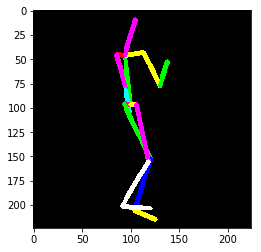

In [11]:
img = np.zeros((224,224,3))
skltn_img = skeleton_image(pose_2d, img)
plt.imshow(skltn_img[:,:,::-1])

In [12]:
pose_2d

array([[100.46611489,  97.28156355],
       [ 94.35242665,  46.87259289],
       [ 85.49755821,  45.47078988],
       [ 95.2219646 ,  81.07977021],
       [ 99.09455041, 105.70685523],
       [113.48185025,  43.41231531],
       [130.08321687,  78.26167796],
       [138.73224165,  52.61351302],
       [105.67557311,   9.61864011],
       [ 93.85393648,  96.53380567],
       [120.68226203, 152.37611742],
       [104.93874305, 206.75058341],
       [125.15487458, 215.68241967],
       [106.77405889,  97.98813603],
       [118.09272993, 155.64993745],
       [ 91.06096901, 201.14149876],
       [120.6481871 , 203.40934387]])

In [13]:
scaled_pose = (pose_2d - 0.)*2./224. - 1.
# scaled_pose = (pose_2d[0] - 0.)*14./512.
map_pose = np.stack([scaled_pose[:,1], scaled_pose[:,0]],1)
map_pose

array([[-0.13141461, -0.10298112],
       [-0.58149471, -0.15756762],
       [-0.5940108 , -0.23662894],
       [-0.27607348, -0.14980389],
       [-0.05618879, -0.11522723],
       [-0.61239004,  0.01323081],
       [-0.30123502,  0.16145729],
       [-0.53023649,  0.23868073],
       [-0.91411928, -0.0564681 ],
       [-0.13809102, -0.16201842],
       [ 0.36050105,  0.0775202 ],
       [ 0.84598735, -0.06304694],
       [ 0.92573589,  0.11745424],
       [-0.12510593, -0.04666019],
       [ 0.38973158,  0.05439937],
       [ 0.79590624, -0.18695563],
       [ 0.81615486,  0.07721596]])

In [14]:
scaled_pose.shape

(17, 2)

In [15]:
def get_limb_centers(joints_2d):

    limbs = []
    angles = []
    limb_length = []
    for i in range(1, joints_2d.shape[0]):
        #         ax.text(joints_2d[i, 0], -joints_2d[i, 1], str(i))
        x_pair = [joints_2d[i, 0], joints_2d[limb_parents[i], 0]]
        y_pair = [joints_2d[i, 1], joints_2d[limb_parents[i], 1]]
        limbs.append([(x_pair[0]+x_pair[1])/2., (y_pair[0]+y_pair[1])/2.])
        limb_length.append(np.sqrt((x_pair[0]-x_pair[1])**2 + (y_pair[0]-y_pair[1])**2))
        # calculate slope, m = tan(theta)
        angles.append([(x_pair[0]-x_pair[1]), (y_pair[0]-y_pair[1])]) # because y is represented as x
    angles = np.array(angles)
    print (angles.shape)
    angles = np.arctan2(angles[:,0],angles[:,1]+1e-7)
    limbs = np.array(limbs)
    limb_length = np.array(limb_length)
    return limbs, angles, limb_length

In [16]:
limb_centers_yx, angles, limb_length = get_limb_centers(map_pose)

(16, 2)


In [17]:
limb_centers_yx.shape

(16, 2)

In [18]:
limb_centers_yx

array([[-0.35645466, -0.13027437],
       [-0.58775276, -0.19709828],
       [-0.43504214, -0.19321642],
       [-0.16613114, -0.13251556],
       [-0.59694237, -0.07216841],
       [-0.45681253,  0.08734405],
       [-0.41573575,  0.20006901],
       [-0.747807  , -0.10701786],
       [-0.13475282, -0.13249977],
       [ 0.11120501, -0.04224911],
       [ 0.6032442 ,  0.00723663],
       [ 0.88586162,  0.02720365],
       [-0.12826027, -0.07482065],
       [ 0.13231283,  0.00386959],
       [ 0.59281891, -0.06627813],
       [ 0.80603055, -0.05486984]])

In [19]:
angles.shape

(16,)

In [20]:
limb_length

array([0.45337818, 0.0800459 , 0.32957963, 0.22258666, 0.17357023,
       0.34465713, 0.24167154, 0.34764957, 0.05941362, 0.55314808,
       0.50542662, 0.19733348, 0.05667315, 0.52466246, 0.47247232,
       0.26494648])

In [48]:
gauss_map1 = get_gaussian_maps(limb_centers_yx, [14,14], 10., 10., angles, mode='rot')

(16, 14, 14)
(16, 14, 14)
(16, 14, 14)


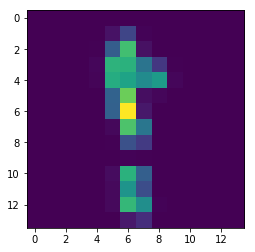

In [49]:
plt.imshow(np.sum(gauss_map1[:,:,:],2))

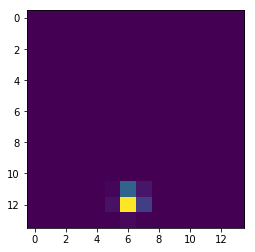

In [50]:
plt.imshow(gauss_map1[:,:,15])

In [23]:
# decreasing the value of ratio increases the length of the gaussian
length_ratios1 = np.array([2., 3., 2., 2.5, 3., 2., 2.5, 3.,
                          1.25, 2.5, 2.5, 1.75, 1.25, 2.5, 2.5, 1.75])
length_ratios = np.ones_like(length_ratios1)*2.
# decreasing the value of ratio increases the width of the gaussian
width_ratios = np.array([8., 25., 20., 25., 25., 20., 25., 12.,
                          20., 15., 20., 20., 20., 15., 20., 20.])

In [53]:
list_centers_list = [limb_centers_yx,limb_centers_yx,limb_centers_yx,limb_centers_yx]
list_centers_arr = np.stack(list_centers_list,0)
rot_gauss_map1 = get_rot_gaussian_maps(list_centers_arr, [28,28], width_ratios, length_ratios / limb_length, angles, mode='rot')

g_yx: 
(16, 28, 28)
g_yx: 
(16, 28, 28)
g_yx: 
(16, 28, 28)
g_yx: 
(16, 28, 28)


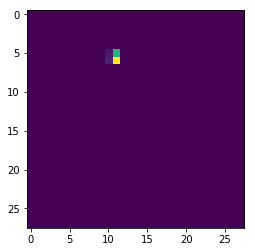

In [54]:
plt.imshow(rot_gauss_map1[1][:,:,1])

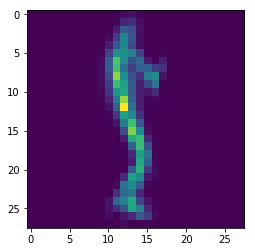

In [55]:
plt.imshow(np.sum(rot_gauss_map1[1][:,:,:],2))

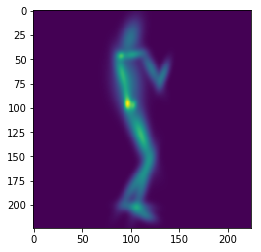

In [52]:
plt.imshow(np.sum(rot_gauss_map1[:,:,:],2))

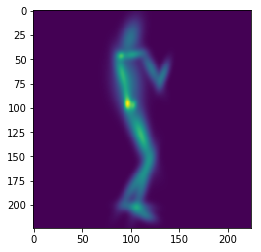

In [53]:
plt.imshow(np.sum(rot_gauss_map1[:,:,:],2))

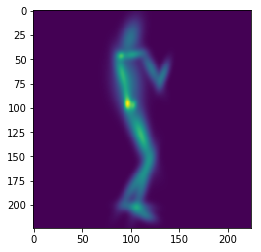

In [54]:
plt.imshow(np.sum(rot_gauss_map1[:,:,:],2))

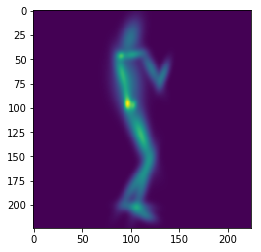

In [55]:
plt.imshow(np.sum(rot_gauss_map1[:,:,:],2))

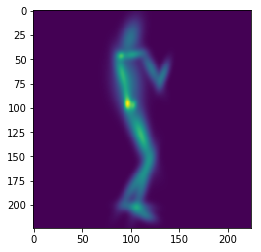

In [56]:
plt.imshow(np.sum(rot_gauss_map1[:,:,:],2))

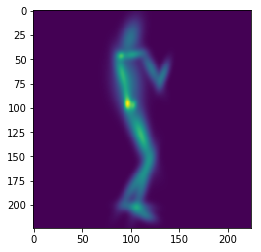

In [57]:
plt.imshow(np.sum(rot_gauss_map1[:,:,:],2))

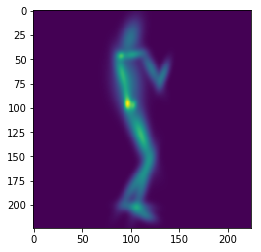

In [58]:
plt.imshow(np.sum(rot_gauss_map1[:,:,:],2))

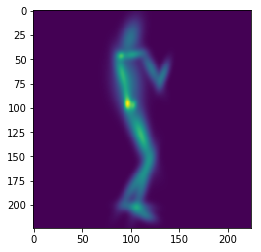

In [59]:
plt.imshow(np.sum(rot_gauss_map1[:,:,:],2))

In [139]:
list_centers_list = [limb_centers_yx,limb_centers_yx,limb_centers_yx,limb_centers_yx]
list_centers_arr = np.stack(list_centers_list,0)
rot_gauss_map1 = get_rot_gaussian_maps_new(list_centers_arr, [224,224], width_ratios, length_ratios / limb_length, angles, mode='rot')

In [140]:
import tensorflow as tf

In [149]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(rot_gauss_map1[0][0])

array([[1.44315533e-022, 1.31497885e-221, 9.86027711e-079, ...,
        6.03742451e-069, 0.00000000e+000, 0.00000000e+000],
       [3.62785081e-022, 1.00352489e-217, 8.51406719e-077, ...,
        1.32080983e-067, 0.00000000e+000, 0.00000000e+000],
       [9.02733291e-022, 6.92660229e-214, 6.92149130e-075, ...,
        2.79032400e-066, 0.00000000e+000, 0.00000000e+000],
       ...,
       [1.07215314e-041, 0.00000000e+000, 2.18201112e-287, ...,
        1.07809602e-141, 2.70030331e-030, 0.00000000e+000],
       [2.83387408e-042, 0.00000000e+000, 3.07710860e-291, ...,
        1.04505688e-143, 1.12334428e-030, 0.00000000e+000],
       [7.41443349e-043, 0.00000000e+000, 4.08548236e-295, ...,
        9.78246227e-146, 4.45279634e-031, 0.00000000e+000]])